# Project Title: Prediction of Air Quality from Traffic Volume in Nova Scotia

## Application of a PCA and K-mean clustering to label average CO-level and comparision between Decision tree and Naive Bayes on the classification task

The current project explored the impact of the traffic in Nova Scotia on air quality, measured by the carbon monoxide (CO) levels of the roadside. The hourly ambient CO data from 2018 to 2020 were obtained from Open Data Nova Scotia [1] consisting of 236,687 observations with the following five features: Date & Time, Pollutant, Unit, Station, and Average. The traffic volume data from 2005 to 2019 were obtained again from Open Data Nova Scotia [2] consisting of 586 observations with the following six features: Date, HIGHWAY, SECTION, SECTION LENGTH, ADT, and AADT. ADT stands for Average Daily Traffic representing the average number of vehicles passing the count location in a 24-hour period. AADT stands for Annual Average Daily Traffic representing the average number of vehicles passing the count location in a 24-hour period, averaged on the basis of one year [2]. 
Both CO data and traffic data were preprocessed before applying machine learning algorithms. The hourly CO data were aggregated by Date to extract the mean CO level per date and restricted to the observations only from 2019. Next, the mean CO level were normalized to a range of 0 to 1. The traffic data were aggregated by Date, HIGHWAY, and SECTION and merged with the CO data, resulting in a final dataset of 426 observations and eight features: Date, HIGHWAY, SECTION, SECTION LENGTH, ADT, AADT, Average. Feature selection was conducted based on f-regression, revealing AADT as the most impactful feature with the highest score.

In [1]:
import pandas as pd

CO_df=pd.read_csv('./dataset/Nova_Scotia_Provincial_Ambient_Carbon_Monoxide__CO__Hourly_Data_Halifax_Johnston.csv')
traffic_df=pd.read_csv('./dataset/cleaned_traffic_data.csv')

In [2]:
import pandas as pd
import numpy as np

#convert Date & Time column to datetime datatype
CO_df['Date & Time']=pd.to_datetime(CO_df['Date & Time'],format='%m/%d/%Y %I:%M:%S %p')
#extract date from timestamp
CO_df['Date']=CO_df['Date & Time'].dt.date
#group by date and extract mean
avgCO_byDate=CO_df.groupby('Date').mean().reset_index()
avgCO_byDate_2019=avgCO_byDate[pd.DatetimeIndex(avgCO_byDate['Date']).year==2019]
avgCO_byDate_2019=pd.DataFrame(avgCO_byDate_2019)
#normalize to a range of 0 to 1
avgCO_byDate_2019['Average']=(avgCO_byDate_2019['Average']-avgCO_byDate_2019['Average'].min())/(avgCO_byDate_2019['Average'].max()-avgCO_byDate_2019['Average'].min())
#discretize with a threshold of 0.5
#avgCO_byDate_2019['Label']=np.where(avgCO_byDate_2019['Average']>=0.5, 'High', 'Low')
avgCO_byDate_2019['Date']=pd.to_datetime(avgCO_byDate_2019['Date'],format='%Y-%m-%d')

In [3]:
import pandas as pd
import numpy as np

#process traffic_df
traffic_df=traffic_df.groupby(['Date','HIGHWAY','SECTION']).mean().reset_index()
traffic_df['Date']=pd.to_datetime(traffic_df['Date'],format='%Y-%m-%d')

In [4]:
#combine CO and traffic data
df=pd.merge(traffic_df,avgCO_byDate_2019,how='inner',on='Date')
df.sort_values(by="Date")
df.info

<bound method DataFrame.info of           Date  HIGHWAY  SECTION  SECTION LENGTH      ADT    AADT   Average
0   2019-04-25      101       50            6.82   7.9515   8.275  0.430693
1   2019-04-25      101       65            2.13   7.9700   8.075  0.430693
2   2019-04-25      101       70            1.71   7.9015   8.220  0.430693
3   2019-04-29      102       20            2.37  26.6680  25.800  0.465347
4   2019-04-29      102       35            3.05  26.0400  25.200  0.465347
..         ...      ...      ...             ...      ...     ...       ...
421 2019-12-09      102       10            1.38  26.5540  27.700  0.000000
422 2019-12-09      102       15            0.82  28.4650  29.700  0.000000
423 2019-12-12      102       25            3.22  30.7500  32.100  0.079208
424 2019-12-18      102       30            1.98  30.3480  32.220  0.465347
425 2019-12-18      118       20            1.76  24.9400  24.770  0.465347

[426 rows x 7 columns]>

Linear regression is designed to make a prediction for a continuous target feature. It uses an error function to measure how well a set of weights fits in the training data. The most common error function is the sum of squared errors (L2), which is the residual sum of squares between the observed true values and the predicted values by the model. The goal of the linear regression is to find a set of optimal weights that would minimize the error the most. To do that, the linear regression starts with a set of random weight values and iteratively make small adjustment to these weights based on the feedback from the error function. To make sure that each step moves downward on the error surface, the linear regression takes the gradient of the error surface at east step [3]. 

To predict the average CO level, the current project applied an ordinary least squares linear regression on the dataset split into train and test based on two time periods (train: April – July, test: August – December). The descriptive features included SECTION LENGTH, ADT, and AADT. Categorical features such as HIGHWAY and SECTION were excluded because the one-hot encoding technique, designed to encode categorial features as a one-hot numeric array for regression tasks, created superabundant number of new columns, which raises the possibility of creating a too complex model that is vulnerable to overfitting. 

Based on the coefficient of each descriptive feature, SECTION LENGTH turned out to be the most relevant features for the prediction (coeff = 6.13e-04) compared to ADT and AADT (-3.33e-05 and 4.91e-05, respectively). However, all the three coefficients were not statistically significant (p > 0.5). Thus, it is difficult to take account the coefficients into the interpretation of the results. For example, we cannot say, “For each increase of SECTION LENGTH, the average CO level will increase by 6.13e-04” because the coefficient is not statistically significant.  

Feature 0: 0.038617
Feature 1: 0.585267
Feature 2: 0.249663
Feature 3: 0.134437
Feature 4: 0.930015


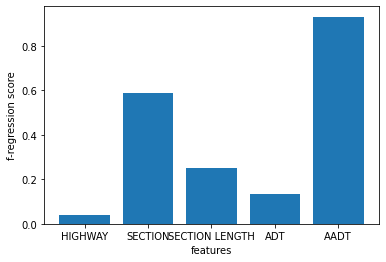

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error, mean_squared_error
 
# feature selection
def select_features(X_train, y_train, X_test):
    # configure to select all features
    fs = SelectKBest(score_func=f_regression, k=3)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # transform train input data
    X_train_fs = fs.transform(X_train)
    # transform test input data
    X_test_fs = fs.transform(X_test)
    return X_train_fs, X_test_fs, fs
 
train=df[(df['Date'].dt.month >= 4) & (df['Date'].dt.month <= 7)]
test=df[(df['Date'].dt.month >= 8) & (df['Date'].dt.month <= 12)]
    
feature_cols=['HIGHWAY','SECTION','SECTION LENGTH','ADT','AADT']
X_train=train[feature_cols]
X_test=test[feature_cols]
y_train=train['Average']
y_test=test['Average']

# feature selection
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
# what are scores for the features
for i in range(len(fs.scores_)):
    print('Feature %d: %f' % (i, fs.scores_[i]))
    # plot the scores
pyplot.bar([i for i in range(len(fs.scores_))], fs.scores_)
pyplot.xticks(np.arange(5),['HIGHWAY','SECTION','SECTION LENGTH','ADT','AADT'])
pyplot.xlabel('features')
pyplot.ylabel('f-regression score')
pyplot.show()

In [6]:
train=df[(df['Date'].dt.month >= 4) & (df['Date'].dt.month <= 7)]
test=df[(df['Date'].dt.month >= 8) & (df['Date'].dt.month <= 12)]

feature_cols=['SECTION LENGTH','ADT','AADT']
X_train=train[feature_cols]
X_test=test[feature_cols]
y_train=train['Average']
y_test=test['Average']

In [7]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_train)
print('Coefficients: ',reg.coef_)
print('Intercept: ',reg.intercept_)

Coefficients:  [ 6.13069489e-04 -3.32856548e-05  4.91128335e-05]
Intercept:  0.3863978920929514


In [8]:
import statsmodels.api as sm
from scipy import stats

X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                Average   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.5460
Date:                Wed, 17 Nov 2021   Prob (F-statistic):              0.651
Time:                        21:31:46   Log-Likelihood:                 191.77
No. Observations:                 271   AIC:                            -375.5
Df Residuals:                     267   BIC:                            -361.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3864      0.017     23.

In [9]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
y_pred = reg.predict(X_test)
# The coefficients
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_test, y_pred))
print("Root mean squared error: %.2f" % np.sqrt(mean_squared_error(y_test, y_pred)))
print("Mean absolute error: %.2f" % mean_absolute_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("R2: %.2f" % r2_score(y_test, y_pred))

Mean squared error: 0.03
Root mean squared error: 0.18
Mean absolute error: 0.14
R2: -0.02


There are several evaluation metrics for linear regression: mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), and R2 coefficient. The MSE captures the average difference between the expected target values in the test set and the values predicted by the model. It allows use to rank the performance of multiple models on a prediction problem with a continuous target. The RMSE is a squared root value of MSE, which allows us to say what the error for predictions made by the model will be as it is in the same unit as the target value. The MAE takes the absolute difference between the target values and predicted values and divide the sum of the differences by the number of observations. It addresses the RMSE’s main problem that it tends to overestimate the error slightly as it overemphasizes individual large errors. Finally, R2 coefficient is a domain independent measure of model performance that is frequently used for prediction problems with a continuous target. The R2 coefficient falls in the range of 0 and 1 and is interpreted as the amount of variation in the target feature that is explained by the descriptive features in the model [3]. 

The linear regression on the current test dataset revealed the MSE of 0.03, the RMSE of 0.18, and the MAE of 0.14, and finally R2 score of -0.02. The negative R2 score especially indicates that the dataset could not fit into the model. 

Aside from the error scores, like mentioned above, the negative R2 score indicates that the model could not fit the data at all. In an attempt to resolve the issue, the normalization of the dataset was done, and the linear regression model was rerun with the same train-test spilt data. Nevertheless, the R2 score still remained negative. Also, a different combination of descriptive features was tried, but no improvement was made. Then, more complex techniques such as polynomial regression, decision tree regressor, and XGBoost were tested, which unfortunately did not bring a significant improvement. As the decision tree and XGBoost are based on linear regression, the models’ poor performance on these tests indicates that the current dataset is too complicated for linear regression. Thus, it is recommended to try a more complex model (e.g., deep learning model, dynamical systems techniques). 

In [10]:
from sklearn.decomposition import PCA
feature_cols=['SECTION LENGTH','ADT','AADT','Average']
X=df[feature_cols]
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

K-means clustering is an unsupervised machine learning algorithm that groups data points in the dataset together into k number of clusters based on certain similarities. The algorithm starts with a set of randomly selected centroids, either an imaginary or real location representing the centre of a cluster, and iteratively performs calculations to optimize the position of the centroids. The positions of the centroids are directed towards minimizing in-cluster sum of squares. The algorithm stops when either the centroids’ positions do not change anymore or when the defined number of iterations are reached [4].

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
range_n_clusters = list(range(2,10))
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(X_pca)
    centers = clusterer.cluster_centers_

    score = silhouette_score(X_pca, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.7920684692401705)
For n_clusters = 3, silhouette score is 0.789008076891186)
For n_clusters = 4, silhouette score is 0.8209067475969024)
For n_clusters = 5, silhouette score is 0.8105628742602307)
For n_clusters = 6, silhouette score is 0.8013875156948194)
For n_clusters = 7, silhouette score is 0.789141821129681)
For n_clusters = 8, silhouette score is 0.7919395832007231)
For n_clusters = 9, silhouette score is 0.7939449403577288)


In [12]:
kmeans = KMeans(n_clusters=4, random_state=0).fit(X_pca)

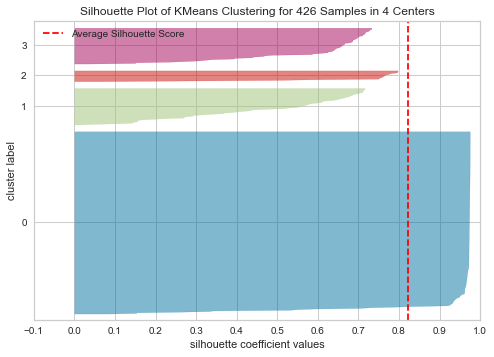

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 426 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [13]:
from yellowbrick.cluster import SilhouetteVisualizer
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')

visualizer.fit(X_pca)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [14]:
df_pca_kmeans=pd.concat([X.reset_index(drop=True), pd.DataFrame(X_pca)], axis=1)

In [15]:
df_pca_kmeans.columns.values[-2:]=['Component 1','Component 2']
df_pca_kmeans['Segment K-means PCA']=kmeans.labels_
df_pca_kmeans

SECTION LENGTH      ADT    AADT   Average  Component 1  Component 2  \
0              6.82   7.9515   8.275  0.430693  -249.394088    -8.657464   
1              2.13   7.9700   8.075  0.430693  -249.536653    -8.812056   
2              1.71   7.9015   8.220  0.430693  -249.483563    -8.661205   
3              2.37  26.6680  25.800  0.465347  -223.782263    -9.542251   
4              3.05  26.0400  25.200  0.465347  -224.648527    -9.520986   
..              ...      ...     ...       ...          ...          ...   
421            1.38  26.5540  27.700  0.000000  -222.519993    -8.120245   
422            0.82  28.4650  29.700  0.000000  -219.756080    -8.061879   
423            3.22  30.7500  32.100  0.079208  -216.436021    -7.985840   
424            1.98  30.3480  32.220  0.465347  -216.638514    -7.616506   
425            1.76  24.9400  24.770  0.465347  -225.733461    -9.045535   

     Segment K-means PCA  
0                      0  
1                      0  
2                      0  
3                      0  
4                      0  
..                   ...  
421                    0  
422                    0  
423                    0  
424                    0  
425                    0  

[426 rows x 7 columns]

In [16]:
df_pca_kmeans['Segment']=df_pca_kmeans['Segment K-means PCA'].map({0: 'class 1', 1:'class 2', 2:'class 3', 3:'class 4'})

C:\Users\dalby\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


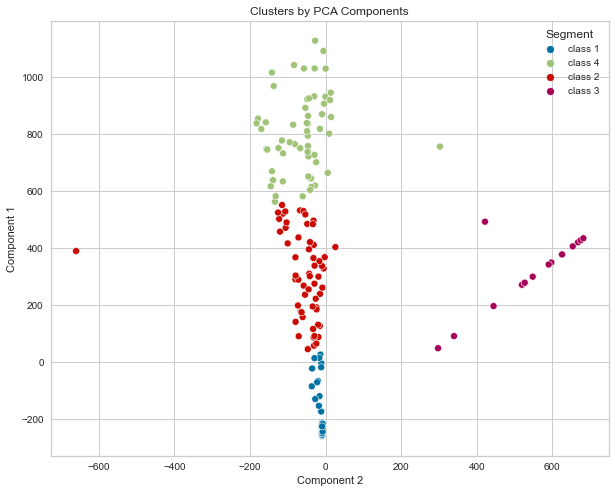

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

x_axis=df_pca_kmeans['Component 2']
y_axis=df_pca_kmeans['Component 1']
plt.figure(figsize=(10,8))
sns.scatterplot(x_axis,y_axis,hue=df_pca_kmeans['Segment'])
plt.title('Clusters by PCA Components')
plt.show()

The K-means clustering based on the principal component analysis (PCA) applied dataset revealed a total of 4 clusters. Due to the 2-dimensional PCA, the interpretability of the results to identify the similarities within each cluster was significantly reduced. Thus, a subsequent visualization of the clusters based on each descriptive feature was conducted. From the visualizations, it was quite obvious the data points formed the clusters based on the different levels of ADT and AADT. In contrast, SECTION LENGTH and the average CO level were displayed with consistent means and standard deviations across the clusters. 

The Silhouette coefficient/score is a value that measures the similarity of an object to its own cluster compared to other clusters. The Silhouette score ranges from -1 to +1 and is often used to determine appropriate clustering configuration. A higher Silhouette score indicates that the model has better defined clusters, whereas a lower Silhouette score indicates less optimal clustering configuration [5]. 

On the PCA-applied dataset, a set of eight Silhouette scores were obtained from a possible number of clustering (a cluster of 2 to 9). A clustering into 4 groups revealed the highest Silhouette score (0.82). Thus, the subsequent K-means algorithm was built with 4 clusters.

C:\Users\dalby\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


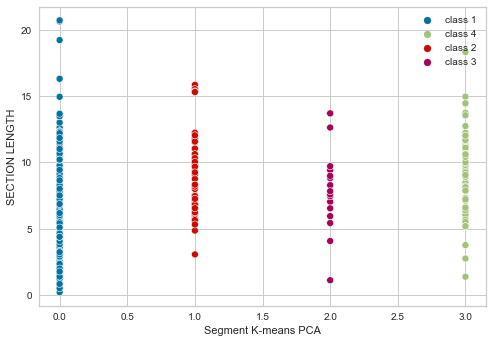

In [18]:
x=df_pca_kmeans['Segment K-means PCA']
y=df_pca_kmeans['SECTION LENGTH']
sns.scatterplot(x,y,hue=df_pca_kmeans['Segment'])
plt.legend(loc="upper right")
plt.show()

C:\Users\dalby\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


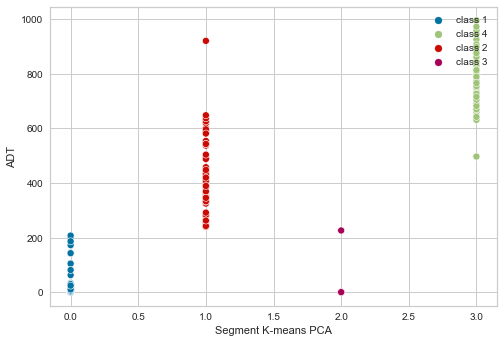

In [19]:
x=df_pca_kmeans['Segment K-means PCA']
y=df_pca_kmeans['ADT']
sns.scatterplot(x,y,hue=df_pca_kmeans['Segment'])
plt.legend(loc="upper right")
plt.show()

C:\Users\dalby\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


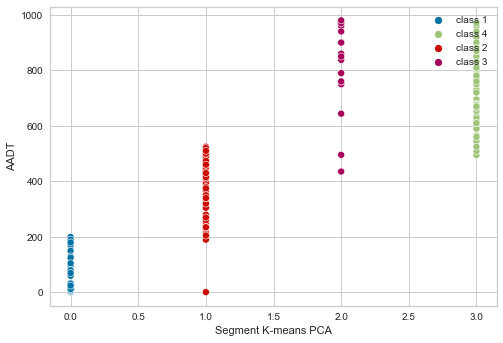

In [20]:
x=df_pca_kmeans['Segment K-means PCA']
y=df_pca_kmeans['AADT']
sns.scatterplot(x,y,hue=df_pca_kmeans['Segment'])
plt.legend(loc="upper right")
plt.show()

C:\Users\dalby\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


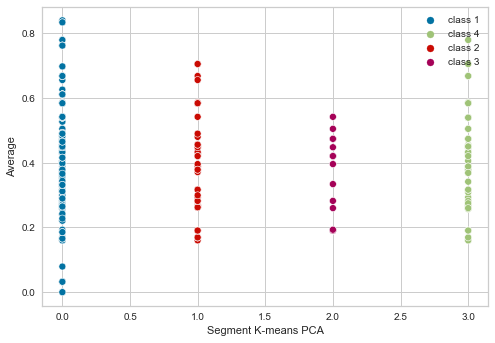

In [21]:
x=df_pca_kmeans['Segment K-means PCA']
y=df_pca_kmeans['Average']
sns.scatterplot(x,y,hue=df_pca_kmeans['Segment'])
plt.legend(loc="upper right")
plt.show()

In [22]:
df2=pd.concat([df, df_pca_kmeans['Segment']], axis=1)
df2.info()
df2.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 426 entries, 0 to 425
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            426 non-null    datetime64[ns]
 1   HIGHWAY         426 non-null    int64         
 2   SECTION         426 non-null    int64         
 3   SECTION LENGTH  426 non-null    float64       
 4   ADT             426 non-null    float64       
 5   AADT            426 non-null    float64       
 6   Average         426 non-null    float64       
 7   Segment         426 non-null    object        
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 30.0+ KB


Date  HIGHWAY  SECTION  SECTION LENGTH      ADT    AADT   Average  \
0 2019-04-25      101       50            6.82   7.9515   8.275  0.430693   
1 2019-04-25      101       65            2.13   7.9700   8.075  0.430693   
2 2019-04-25      101       70            1.71   7.9015   8.220  0.430693   
3 2019-04-29      102       20            2.37  26.6680  25.800  0.465347   
4 2019-04-29      102       35            3.05  26.0400  25.200  0.465347   

   Segment  
0  class 1  
1  class 1  
2  class 1  
3  class 1  
4  class 1

Accuracy: 0.907
Classification report:
              precision    recall  f1-score   support

     class 1       1.00      0.99      0.99        76
     class 2       0.91      1.00      0.95        10
     class 3       0.17      0.20      0.18         5
     class 4       0.73      0.69      0.71        16

    accuracy                           0.91       107
   macro avg       0.70      0.72      0.71       107
weighted avg       0.91      0.91      0.91       107

Confusion matrix:


1.0

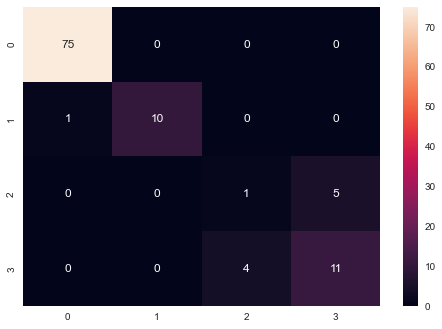

In [23]:
# Load libraries
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_curve, roc_auc_score
import seaborn as sns
from matplotlib import pyplot as plt
# Split the data into train and test
#train=df2[(df2['Date'].dt.month >= 4) & (df2['Date'].dt.month <= 7)]
#test=df2[(df2['Date'].dt.month >= 8) & (df2['Date'].dt.month <= 12)]

feature_cols=['SECTION LENGTH','AADT']
#X_train=train[feature_cols]
#X_test=test[feature_cols]
#y_train=train['Segment']
#y_test=test['Segment']

X=df2[feature_cols]
y=df2['Segment']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=1)

# Create Decision Tree classifer object
clf=DecisionTreeClassifier(criterion='entropy')

# Train Decision Tree Classifer
clf=clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred=clf.predict(X_test)

# Evaluation metrics
accuracy=accuracy_score(y_test,y_pred)
report=classification_report(y_pred,y_test)
cm=confusion_matrix(y_test,y_pred)

print("Accuracy:",'%.3f' % accuracy)
print("Classification report:")
print(report)
print("Confusion matrix:")
sns.heatmap(cm,annot=True)

clf.score(X_train,y_train)

C:\Users\dalby\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


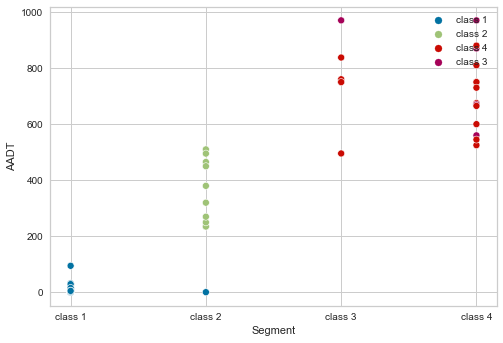

In [24]:
sns.scatterplot(y_test,X_test['AADT'],hue=y_pred)
plt.legend(loc="upper right")
plt.show()

C:\Users\dalby\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


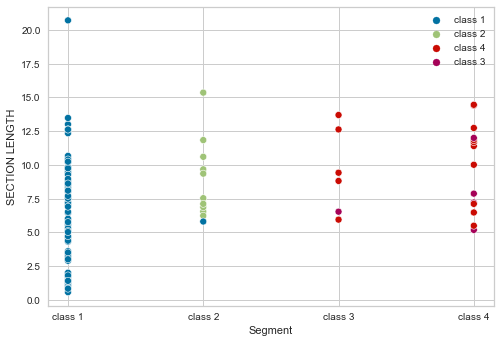

In [25]:
sns.scatterplot(y_test,X_test['SECTION LENGTH'],hue=y_pred)
plt.legend(loc="upper right")
plt.show()

In [26]:
y_test_modified = pd.DataFrame(y_test).reset_index()
y_test_modified.columns = ['index', 'y_test']
y_test_modified = y_test_modified['y_test']

y_pred = pd.DataFrame(y_pred,columns=['y_pred_DT'])
tb1 = pd.concat([y_test_modified,y_pred],axis=1)

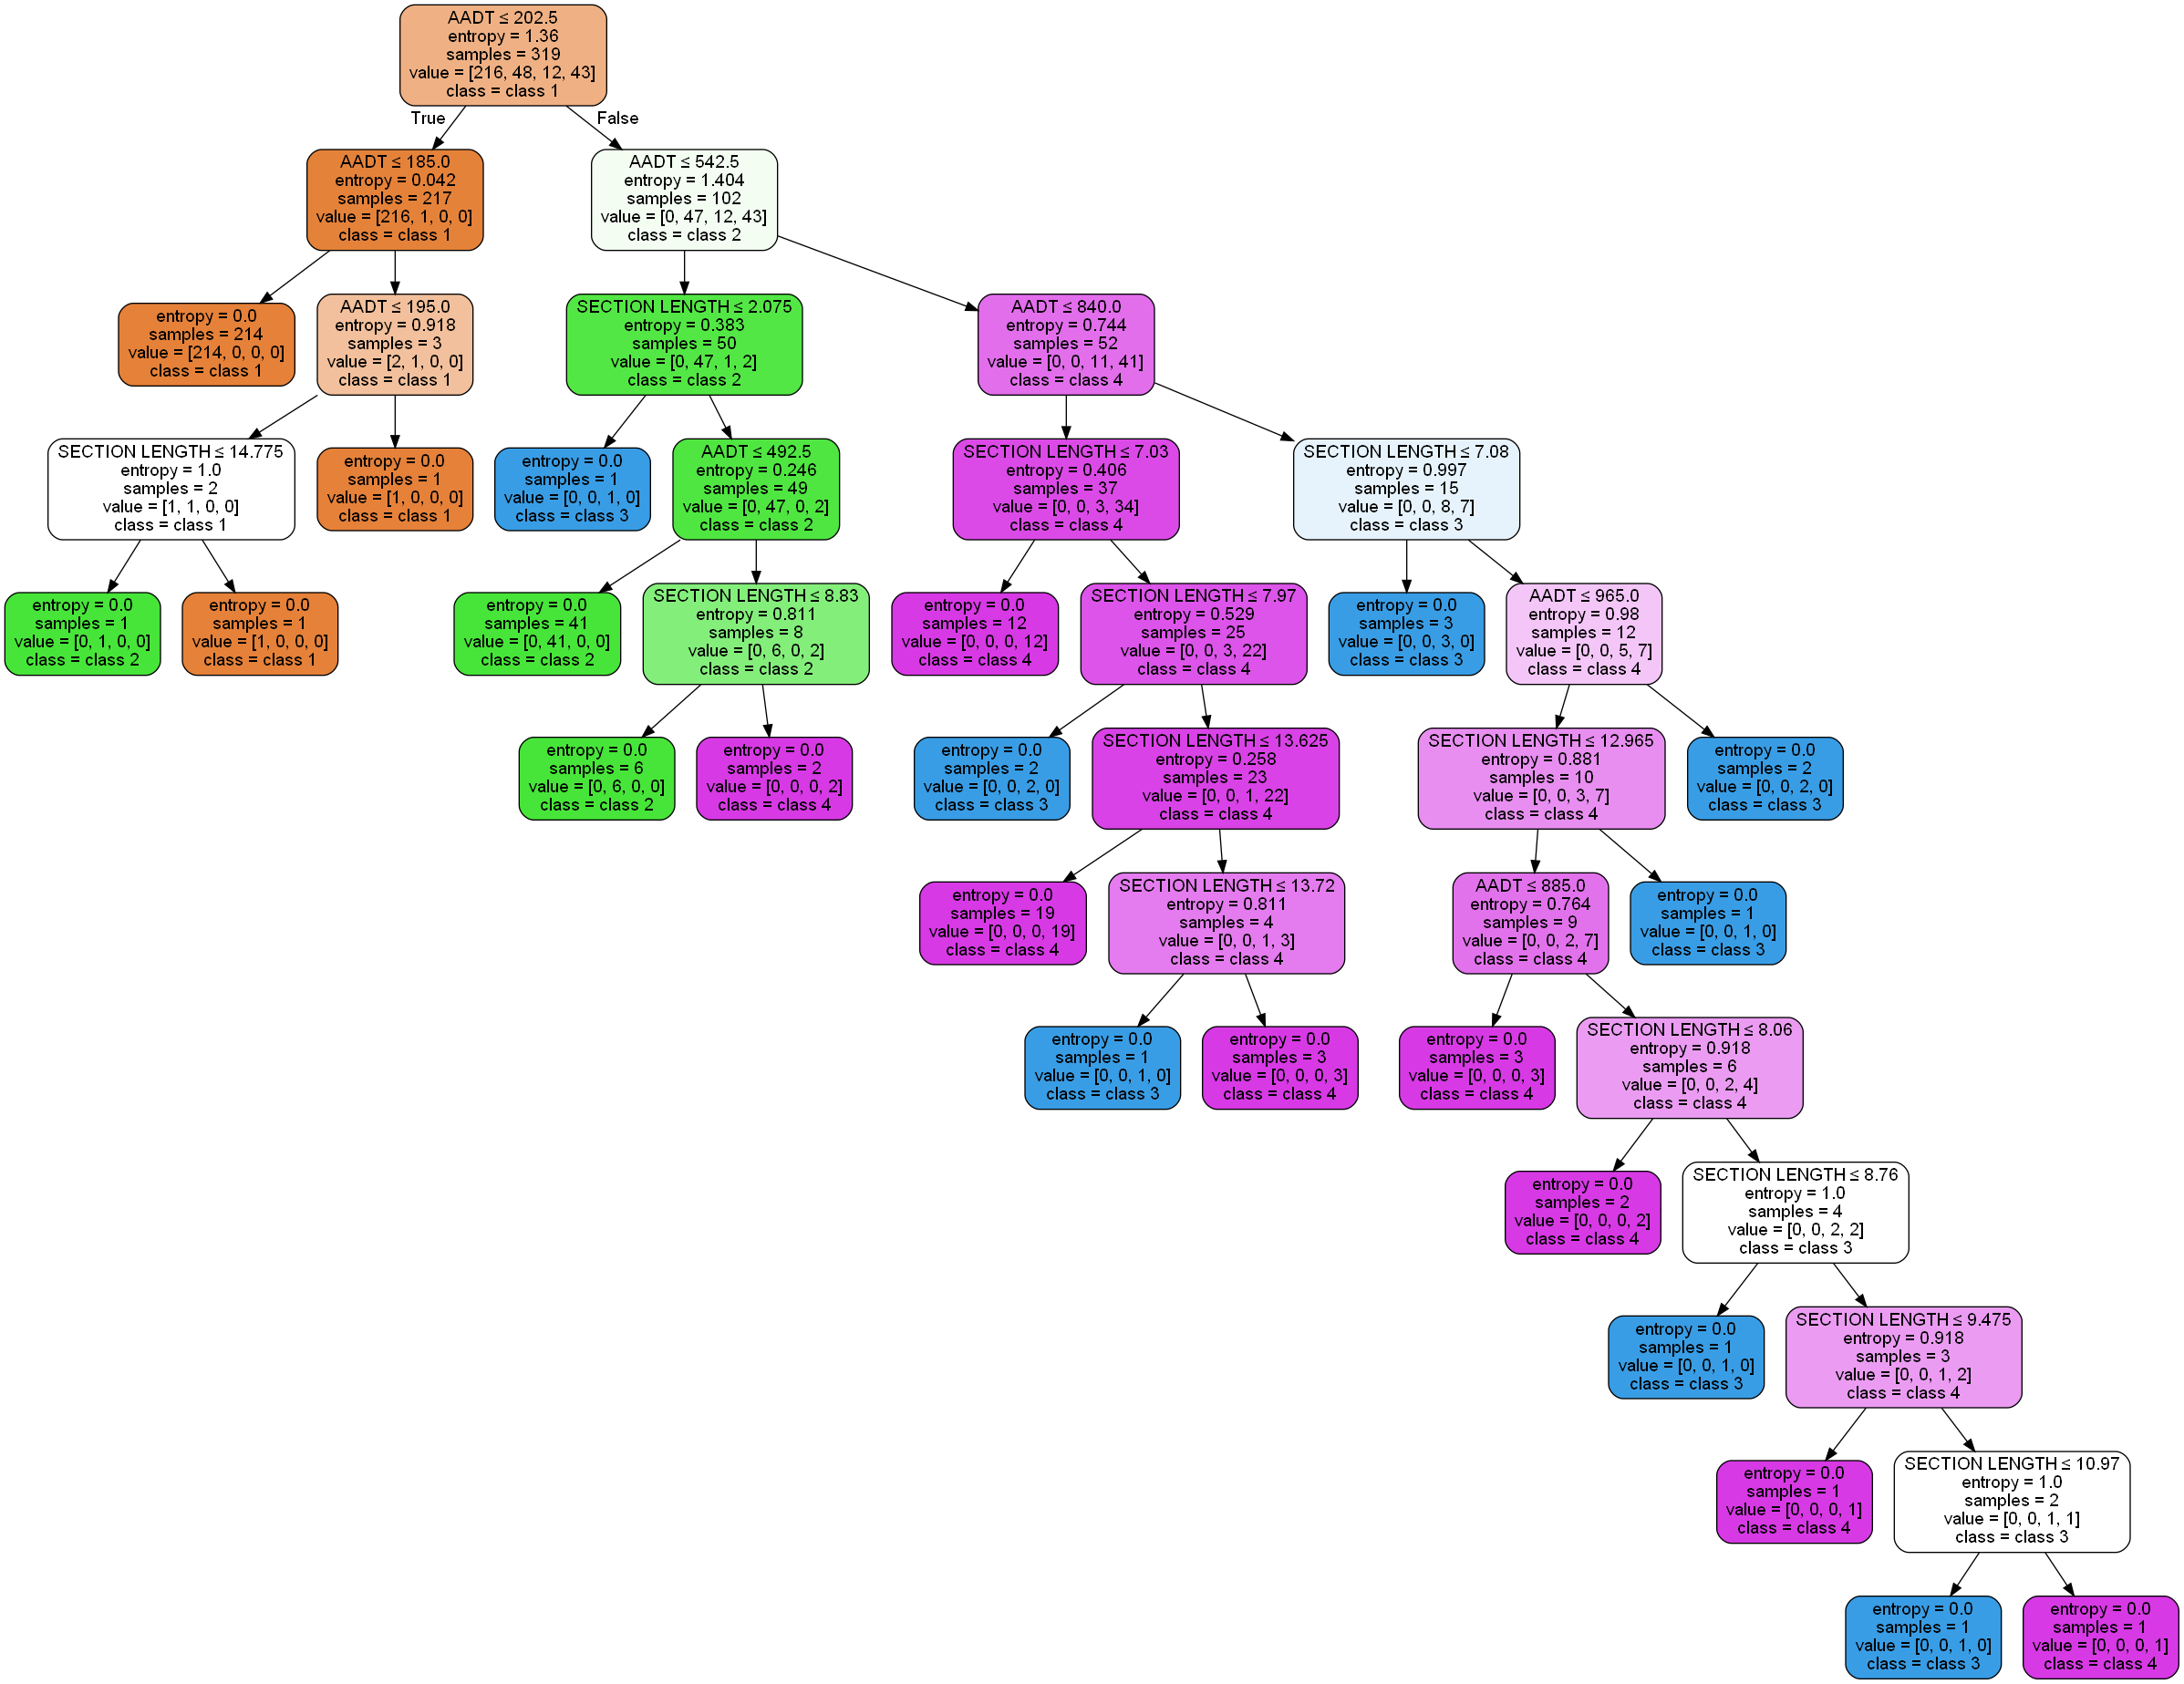

In [27]:
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
import pydotplus

dot_data=StringIO()
export_graphviz(clf,out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['class 1','class 2','class 3','class 4'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
Image(graph.create_png())

Number of mislabeled points out of a total 107 points : 9
Accuracy: 0.916
Classification report:
              precision    recall  f1-score   support

     class 1       1.00      0.99      0.99        76
     class 2       0.91      0.77      0.83        13
     class 3       0.17      0.50      0.25         2
     class 4       0.80      0.75      0.77        16

    accuracy                           0.92       107
   macro avg       0.72      0.75      0.71       107
weighted avg       0.94      0.92      0.93       107

Confusion matrix:


<AxesSubplot:>

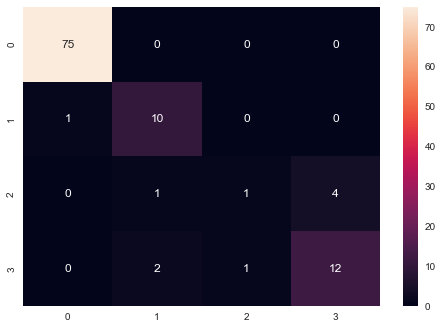

In [28]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb = gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)
print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
print('Accuracy: %.3f' % gnb.score(X_test,y_test))
report=classification_report(y_pred,y_test)
print("Classification report:")
print(report)
cm=confusion_matrix(y_test,y_pred)
print("Confusion matrix:")
sns.heatmap(cm,annot=True)

C:\Users\dalby\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


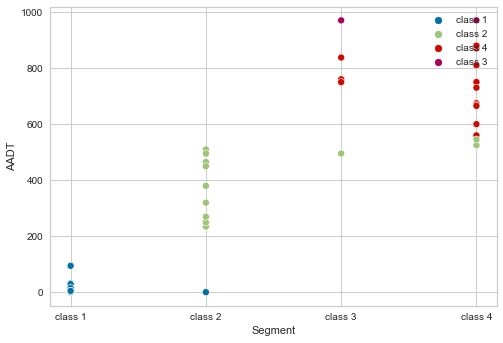

In [29]:
sns.scatterplot(y_test,X_test['AADT'],hue=y_pred)
plt.legend(loc="upper right")
plt.show()

C:\Users\dalby\opencv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


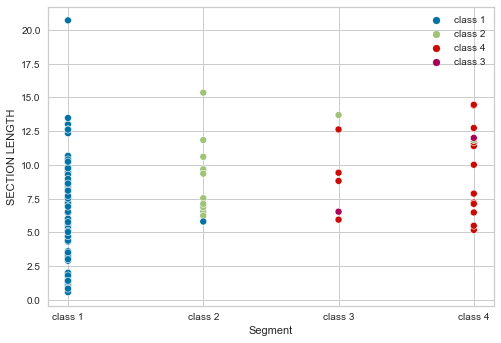

In [30]:
sns.scatterplot(y_test,X_test['SECTION LENGTH'],hue=y_pred)
plt.legend(loc="upper right")
plt.show()

In [31]:
y_pred = pd.DataFrame(y_pred,columns=['y_pred_NB'])
tb2 = pd.concat([y_test_modified,y_pred],axis=1)

In [32]:
#https://towardsdatascience.com/naive-bayes-classifier-how-to-successfully-use-it-in-python-ecf76a995069

import plotly.express as px  # for data visualization
import plotly.graph_objects as go # for data visualization

# Specify a size of the mesh to be used
mesh_size = 5
margin = 1

# Create a mesh grid on which we will run our model
x_min, x_max = X.iloc[:, 0].fillna(X.mean()).min() - margin, X.iloc[:, 0].fillna(X.mean()).max() + margin
y_min, y_max = X.iloc[:, 1].fillna(X.mean()).min() - margin, X.iloc[:, 1].fillna(X.mean()).max() + margin
xrange = np.arange(x_min, x_max, mesh_size)
yrange = np.arange(y_min, y_max, mesh_size)
xx, yy = np.meshgrid(xrange, yrange)

# Create classifier, run predictions on grid
Z = gnb.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
Z = Z.reshape(xx.shape)

# Specify traces 
trace_specs = [
    #[X_train, y_train, 0, 'Train', 'brown'],
    #[X_train, y_train, 1, 'Train', 'aqua'],
    [X_test, y_test, 'class 1', 'Test', 'red'],
    [X_test, y_test, 'class 2', 'Test', 'blue'],
    [X_test, y_test, 'class 3', 'Test', 'green'],
    [X_test, y_test, 'class 4', 'Test', 'yellow']
]

# Build the graph using trace_specs from above
fig = go.Figure(data=[
    go.Scatter(
        x=X[y==labels].iloc[:, 0], y=X[y==labels].iloc[:, 1],
        name=f'{split} data, Actual Class: {labels}',
        mode='markers', marker_color=marker
    )
    for X, y, labels, split, marker in trace_specs
])

# Update marker size
fig.update_traces(marker_size=5, marker_line_width=0)

# Update axis range
fig.update_xaxes(range=[-2, 20])
fig.update_yaxes(range=[-50,1000])

# Update chart title and legend placement
fig.update_layout(title_text="Decision Boundary for Naive Bayes Model", 
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))

# Add contour graph
fig.add_trace(
    go.Contour(
        x=xrange,
        y=yrange,
        z=Z,
        showscale=True,
        colorscale='magma',
        opacity=1,
        name='Score',
        hoverinfo='skip'
    )
)

fig.show()

C:\Users\dalby\opencv\lib\site-packages\sklearn\base.py:442: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  "X does not have valid feature names, but"


Once the categorical target feature called Segment with 4 levels (Class 1 – Class 4) was created using the K-means clustering, it was merged with the initial non-PCA applied dataset. Then, a decision tree and a Gaussian-based Naïve Bayes were applied to classify the target feature Segment based on two descriptive features (SECTION LENGTH and AADT). ADT was excluded this time because 1) it was the lowest priority in the feature selection out of the three features (SECTION LENGTH, ADT, AADT) and 2) the K-means clustering identified as ADT having a similar impact as AADT on the classification of the classes. The decision tree and the Naïve Bayes model achieved the accuracy of 0.907 and 0.916, respectively. Interestingly, both models did a relatively poor prediction for distinguishing Class 3 from Class 4 as shown in the confusion matrixes as well as in the decision boundary.

Accuracy score, represented as the sum of true positive (TP) and true negative (TN) divided by the total sample size, was chosen as the main evaluation matric for both the decision tree and the Naïve Bayes classifier. Besides the accuracy score, precision, recall, f1-score were chosen as well to examine class-specific prediction accuracy. Area under the curve (AUC) score, another popular evaluation metric for classification tasks, was not chosen because the current classification task is designed to classify more than two labels (multi-label classification).

In [33]:
# contruct a contingency table
contng=pd.concat([tb1,tb2],axis=1)
contng=contng.loc[:,~contng.columns.duplicated()]

contng.loc[contng['y_test'] == contng['y_pred_DT'], 'DT_correct'] = 1
contng.loc[contng['y_test'] != contng['y_pred_DT'], 'DT_incorrect'] = 1
contng.loc[contng['y_test'] == contng['y_pred_NB'], 'NB_correct'] = 1
contng.loc[contng['y_test'] != contng['y_pred_NB'], 'NB_incorrect'] = 1

both_correct=len(contng[(contng['DT_correct']==1) & (contng['NB_correct']==1)])
both_incorrect=len(contng[(contng['DT_incorrect']==1) & (contng['NB_incorrect']==1)])
only_DT_correct=len(contng[(contng['DT_correct']==1) & (contng['NB_incorrect']==1)])
only_NB_correct=len(contng[(contng['DT_incorrect']==1) & (contng['NB_correct']==1)])

In [34]:
contng

y_test y_pred_DT y_pred_NB  DT_correct  DT_incorrect  NB_correct  \
0    class 1   class 1   class 1         1.0           NaN         1.0   
1    class 1   class 1   class 1         1.0           NaN         1.0   
2    class 1   class 1   class 1         1.0           NaN         1.0   
3    class 2   class 2   class 2         1.0           NaN         1.0   
4    class 1   class 1   class 1         1.0           NaN         1.0   
..       ...       ...       ...         ...           ...         ...   
102  class 2   class 1   class 1         NaN           1.0         NaN   
103  class 1   class 1   class 1         1.0           NaN         1.0   
104  class 1   class 1   class 1         1.0           NaN         1.0   
105  class 4   class 3   class 3         NaN           1.0         NaN   
106  class 4   class 4   class 4         1.0           NaN         1.0   

     NB_incorrect  
0             NaN  
1             NaN  
2             NaN  
3             NaN  
4             NaN  
..            ...  
102           1.0  
103           NaN  
104           NaN  
105           1.0  
106           NaN  

[107 rows x 7 columns]

In [35]:
from scipy.stats import chisquare

exp_num_class1=len(contng[contng['y_test']=='class 1'])
exp_num_class2=len(contng[contng['y_test']=='class 2'])
exp_num_class3=len(contng[contng['y_test']=='class 3'])
exp_num_class4=len(contng[contng['y_test']=='class 4'])

DT_obs_num_class1=len(contng[(contng['y_test']=='class 1') & (contng['y_pred_DT']=='class 1')])
DT_obs_num_class2=len(contng[(contng['y_test']=='class 2') & (contng['y_pred_DT']=='class 2')])
DT_obs_num_class3=len(contng[(contng['y_test']=='class 3') & (contng['y_pred_DT']=='class 3')])
DT_obs_num_class4=len(contng[(contng['y_test']=='class 4') & (contng['y_pred_DT']=='class 4')])

NB_obs_num_class1=len(contng[(contng['y_test']=='class 1') & (contng['y_pred_NB']=='class 1')])
NB_obs_num_class2=len(contng[(contng['y_test']=='class 2') & (contng['y_pred_NB']=='class 2')])
NB_obs_num_class3=len(contng[(contng['y_test']=='class 3') & (contng['y_pred_NB']=='class 3')])
NB_obs_num_class4=len(contng[(contng['y_test']=='class 4') & (contng['y_pred_NB']=='class 4')])

In [36]:
table_DT_NB = [[DT_obs_num_class1,DT_obs_num_class2,DT_obs_num_class3,DT_obs_num_class4],
         [NB_obs_num_class1,NB_obs_num_class2,NB_obs_num_class3,NB_obs_num_class4]]

table_DT_NB

[[75, 10, 1, 11], [75, 10, 1, 12]]

In [37]:
# chi-squared test with similar proportions
from scipy.stats import chi2_contingency
from scipy.stats import chi2

stat, p, dof, expected = chi2_contingency(table_DT_NB)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

dof=3
[[74.61538462  9.94871795  0.99487179 11.44102564]
 [75.38461538 10.05128205  1.00512821 11.55897436]]
probability=0.950, critical=7.815, stat=0.038
Independent (fail to reject H0)
significance=0.050, p=0.998
Independent (fail to reject H0)


In [38]:
table_DT_test = [[DT_obs_num_class1,DT_obs_num_class2,DT_obs_num_class3,DT_obs_num_class4],
         [exp_num_class1,exp_num_class2,exp_num_class3,exp_num_class4]]

stat, p, dof, expected = chi2_contingency(table_DT_test)
print(table_DT_test)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[75, 10, 1, 11], [75, 11, 6, 15]]
dof=3
[[71.32352941  9.98529412  3.32843137 12.3627451 ]
 [78.67647059 11.01470588  3.67156863 13.6372549 ]]
probability=0.950, critical=7.815, stat=3.753
Independent (fail to reject H0)
significance=0.050, p=0.289
Independent (fail to reject H0)


In [39]:
table_NB_test = [[NB_obs_num_class1,NB_obs_num_class2,NB_obs_num_class3,NB_obs_num_class4],
         [exp_num_class1,exp_num_class2,exp_num_class3,exp_num_class4]]

stat, p, dof, expected = chi2_contingency(table_NB_test)
print(table_DT_test)
print('dof=%d' % dof)
print(expected)
# interpret test-statistic
prob = 0.95
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
# interpret p-value
alpha = 1.0 - prob
print('significance=%.3f, p=%.3f' % (alpha, p))
if p <= alpha:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')

[[75, 10, 1, 11], [75, 11, 6, 15]]
dof=3
[[71.70731707 10.03902439  3.34634146 12.90731707]
 [78.29268293 10.96097561  3.65365854 14.09268293]]
probability=0.950, critical=7.815, stat=3.564
Independent (fail to reject H0)
significance=0.050, p=0.313
Independent (fail to reject H0)


In [40]:
# Source: https://machinelearningmastery.com/mcnemars-test-for-machine-learning/
from statsmodels.stats.contingency_tables import mcnemar
# define contingency table
table = [[both_correct, only_DT_correct],
         [only_NB_correct, both_incorrect]]
# calculate mcnemar test
result = mcnemar(table, exact=True)
# summarize the finding
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
# interpret the p-value
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors (fail to reject H0)')
else:
    print('Different proportions of errors (reject H0)')

statistic=2.000, p-value=1.000
Same proportions of errors (fail to reject H0)


The Naïve Bayes had a slightly higher accuracy score (0.907 vs. 0.916). Pearson’s chi-squared test was conducted in order to compare the classification of Class 1 to Class 4 between the decision tree and Naïve Bayes classifier. The chi-squared test revealed that the classification of Class 1 to Class 4 is not statistically different between the two models (p = 0.998). The same test was done to compare the observed classification frequencies of each model to the expected classification frequencies of the test dataset. Both the classification frequencies from the decision tree and the Naivs Bayes were not statistically different from the test dataset (p = 0.289 and p = 0.313, respectively).A slightly higher accuracy score of the Naïve Bayes model compared to the decision tree was attributed to the fact that the Naïve Bayes did a relatively better job in sorting Class 3 from Class 4. This again is shown from a higher recall score for Class 3 for the Naïve Bayes compared to the one for the decision tree. One interesting discovery is that, for the decision tree model, the discrepancy between the training accuracy and test accuracy was higher than the Naïve Bayes. This observation is consistent with the well-known characteristic of a Naïve Bayes model in comparison to a decision tree model: overfitting tends to occur less frequently with the Naïve Bayes compared to the decision tree models.

The patterns found by the supervised models (Decision Tree and Naïve Bayes) were consistent with the one presented in the clustering specifically for Class 1 and 2. For Class 3 and 4, the supervised models failed to capture the correct classification because many instances that actually belonged to Class 3 were classified as Class 4. This issue was resolved when ADT was added as another descriptive feature. 


### Summary of Results and Conclusions

The CO level and traffic volume combined dataset yielded 426 observations consisting of 3 descriptive features (SECTION LENGTH, ADT, AADT) and 1 target feature (Average CO level) and was split into training and test dataset based on distinctive time frames (April – July, August – December). Ordinary least squares linear regression was applied to predict the average CO level, which poorly performed due to the non-linearity of the dataset. Next, a 2-dimensional PCA was conducted to reduce the dimensionality of the dataset for the easiness of classification and visualization for the subsequent K-means clustering. A set of Silhouette scores was extracted, which brought the highest score for the clustering into 4 groups. This determined the most appropriate clustering for the K-means. Finally, a Decision Tree and Naïve Bayes classifier were built to conduct the classification task for the 4 classes that were previously labeled by the K-means algorithm. The two supervised models performed the classification task with two descriptive features (SECTION LENGTH, AADT). Both models revealed accuracy scores around 0.90 (0.907 for DT and 0.916 for NB, respectively) and their classification tasks were not statistically different from each other (p > 0.05) based on the chi-squared test. Interestingly, the decision tree model performed poorly when it comes to sorting Class 3 as it misclassified many instances in Class 3 into Class 4. However, the issue was resolved when ADT was introduced as an additional descriptive feature. In general, the patterns for Class 1 and 2 for supervised models matched quite well, observed by that the two classes had distinctive ADT levels displayed.   

### References

[1] 	Open Data Nova Scotia, "Nova Scotia Government - Open Data Portal," 5 August 2021. [Online]. Available: https://data.novascotia.ca/Environment-and-Energy/Nova-Scotia-Provincial-Ambient-Carbon-Monoxide-CO-/8tvc-9ah2. [Accessed November 2021].
[2] 	Open Data Nova Scotia, "Nova Scotia Government - Open Data Portal," 9 June 2021. [Online]. Available: https://data.novascotia.ca/Roads-Driving-and-Transport/Traffic-Volumes-Provincial-Highway-System/8524-ec3n. [Accessed November 2021].
[3] 	J. Kelleher, B. M. Namee and A. D'arcy, Fundementals of Machine Learning for Predictive Data Analytics, Cambride, Massachusetts: The MIT Press, 2015. 
[4] 	M. J. Garbade, "Understanding K-means Clustering in Machine Learning," towards data science, 12 September 2018. [Online]. Available: https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1. [Accessed November 2021].
[5] 	P. J. Rousseeuw, "Silhouettes: A graphical aid to the interpretation and validation of cluster analysis," Journal of Computational and Applied Mathematics, vol. 20, pp. 53-65, 1987. 
